In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img 
import geopandas as gpd
from shapely.geometry import Point
from scipy import spatial, interpolate
import warnings
warnings.filterwarnings("ignore")

/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/geospaNN/utils.py:713: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if X_pattern is "uniform":
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/geospaNN/utils.py:715: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif X_pattern is "correlated":
R[write to console]: Loading required package: BRISC

R[write to console]: Loading required package: RANN

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rdist

R[write to console]: Loading required package: matrixStats

R[write to console]: Loading required package: pbapply

R[write to console]: The ordering of inputs x (covariates) and y (response) in BRISC_estimation has been changed BRISC 1.0.0 onwards.
  Please check the new documentation with ?BRISC_estimation.



R package: BRISC installed


/Users/zhanwentao/opt/anaconda3/envs/NN/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_nation_20m.zip"
us = gpd.read_file(url).explode()
us = us.loc[us.geometry.apply(lambda x: x.exterior.bounds[2])<-60]

In [3]:
df_covariates = pd.read_csv('./data/covariate0605.csv')
df_pm25 = pd.read_csv('./data/pm25_0605.csv')
df_pm25 = df_pm25.loc[df_pm25.Latitude < 50]

x_min,y_min,x_max,y_max = np.array([np.min(df_covariates['long']), np.min(df_covariates['lat']),
    np.max(df_covariates['long']), np.max(df_covariates['lat'])])
arr1 = np.mgrid[x_min:x_max:101j, y_min:y_max:101j]

# extract the x and y coordinates as flat arrays
arr1x = np.ravel(arr1[0])
arr1y = np.ravel(arr1[1])
# using the X and Y columns, build a dataframe, then the geodataframe
df = pd.DataFrame({'X':arr1x, 'Y':arr1y})
df['coords'] = list(zip(df['X'], df['Y']))
df['coords'] = df['coords'].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.X, y=df.Y),crs = us.crs)
inUS = gdf['geometry'].apply(lambda s: s.within(us.geometry.unary_union))

In [4]:
lonlat_pm25=df_pm25.values[:,[1,2]]
near = df_covariates.values[:,[1,2]]
tree = spatial.KDTree(list(zip(near[:,0].ravel(), near[:,1].ravel())))
idx = tree.query(lonlat_pm25)[1]
df_pm25_mean = df_pm25.assign(neighbor = idx).groupby('neighbor')['PM25'].mean()
idx_new = df_pm25_mean.index.values
pm25 = df_pm25_mean.values
z = pm25[:,None]

lon = df_covariates.values[:,1]
lat = df_covariates.values[:,2]

f = interpolate.Rbf(lon[idx_new], lat[idx_new], z, function = 'inverse')
x_test = gdf.loc[inUS,:].X
y_test = gdf.loc[inUS,:].Y
z_test = f(x_test, y_test)

In [5]:
import numpy as np

lon = df_covariates.values[:, 1]
lat = df_covariates.values[:, 2]
covariates = df_covariates.values[:, 3:]
normalized_lon = (lon - min(lon)) / (max(lon) - min(lon))
normalized_lat = (lat - min(lat)) / (max(lat) - min(lat))
normalized_x_test = (x_test - min(lon)) / (max(lon) - min(lon))
normalized_y_test = (y_test - min(lat)) / (max(lat) - min(lat))

s_obs = np.vstack((normalized_lon[idx_new], normalized_lat[idx_new])).T
X = covariates[idx_new, :]
normalized_X = X
for i in range(X.shape[1]):
    normalized_X[:, i] = (X[:, i] - min(X[:, i])) / (max(X[:, i]) - min(X[:, i]))

X = normalized_X
Y = z.reshape(-1)
coord = s_obs
data = np.concatenate([X, Y.reshape(-1,1), coord], axis = 1)
#columns = ['precipitation', 'temperature', 'air pressure', 'relative humidity', 'U-wind', 'V-wind',
#          'PM 2.5', 'longitude', 'latitude']
#df = pd.DataFrame(data=data, index=range(data.shape[0]), columns=columns)
#df.to_csv('./data/Normalized_PM2.5_20190605.csv')

In [6]:
data_PM25 = pd.read_csv("./data/Normalized_PM2.5_20190605.csv")
data_PM25

Unnamed: 0  precipitation  temperature  air pressure  relative humidity  \
0             0       0.008044     0.362296      0.887664           0.774197   
1             1       0.005516     0.355305      0.882153           0.751742   
2             2       0.000000     0.335323      0.928359           0.714189   
3             3       0.000000     0.338579      0.954218           0.690767   
4             4       0.002528     0.293827      0.893599           0.685830   
..          ...            ...          ...           ...                ...   
600         600       0.393932     0.901079      0.972022           0.910279   
601         601       0.000689     0.810329      0.897414           0.539392   
602         602       0.294415     0.882501      0.972022           0.822590   
603         603       0.011492     0.811830      0.965240           0.719028   
604         604       0.256952     0.775792      0.975837           0.802168   

       U-wind    V-wind    PM 2.5  longitude  latitude  
0    0.868530  0.781498  5.020834   0.980311  0.906268  
1    0.864206  0.770715  3.837500   0.983093  0.889762  
2    0.697080  0.813224  2.041666   0.974238  0.814722  
3    0.625266  0.868161  3.669444   0.976951  0.798275  
4    0.688808  0.842395  1.020833   0.945193  0.800337  
..        ...       ...       ...        ...       ...  
600  0.642436  0.469410  5.168750   0.469337  0.101640  
601  0.553265  0.464926  6.041666   0.436702  0.098054  
602  0.642248  0.469353  8.704166   0.468665  0.090378  
603  0.676463  0.512429  8.725000   0.460179  0.035680  
604  0.696516  0.509137  8.213636   0.470595  0.032926  

[605 rows x 10 columns]

In [7]:
X = torch.from_numpy(data_PM25[['precipitation', 'temperature', 'air pressure', 'relative humidity', 'U-wind', 'V-wind']].to_numpy()).float()
Y = torch.from_numpy(data_PM25[['PM 2.5']].to_numpy().reshape(-1)).float()
coord = torch.from_numpy(data_PM25[['longitude', 'latitude']].to_numpy()).float()

p = X.shape[1]

n = X.shape[0]
nn = 20
batch_size = 50

X, Y, coord, _ = geospaNN.spatial_order(X, Y, coord, method = 'max-min')
data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size = 20, 
                                                   test_proportion = 0.5)

In [8]:
start_time = time.time()
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
nn_model = geospaNN.nn_train(mlp_nn, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)

Epoch 00041: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00049: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch52


In [10]:
theta0 = geospaNN.theta_update(torch.tensor([1, 1.5, 0.01]), mlp_nn(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = geospaNN.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 20, Update_step = 10)
end_time = time.time()

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 181 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[9.9655597  8.90524852 0.17623602]
Epoch 00020: reducing learning rate of group 0 to 5.0000e-03.
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 181 observations.

Number of covariates 1 (including intercept if specif

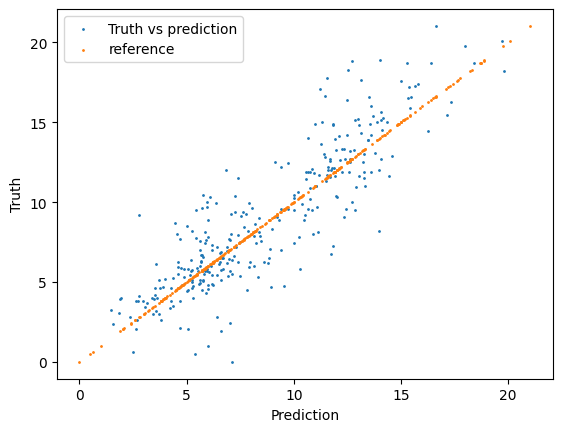

In [11]:
[test_predict, test_U, test_L] = model.predict(data_train, data_test, CI = True)
plt.clf()
plt.scatter(test_predict.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'Truth vs prediction')
plt.scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'reference')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()
plt.show()

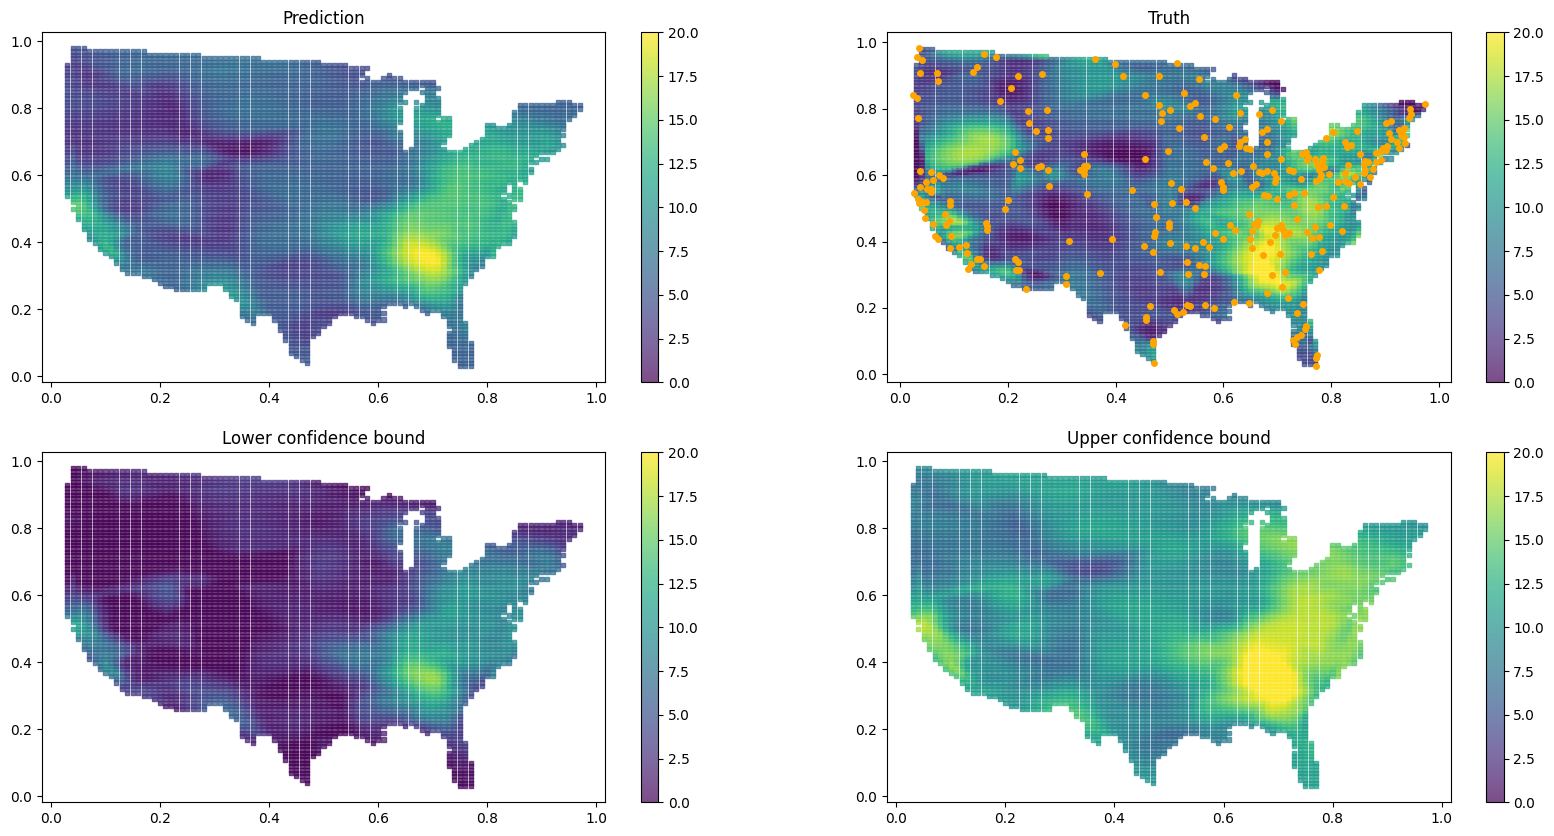

In [12]:
f_pred = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                test_predict.detach().numpy())
f_U = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                test_U.detach().numpy())
f_L = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                test_L.detach().numpy())
f_true = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                data_test.y.detach().numpy())


titles = np.array([['Prediction', 'Truth'], ['Lower confidence bound', 'Upper confidence bound']])
f_vec = np.array([[f_pred, f_true], [f_L, f_U]])

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i in range(2):
    for j in range(2):
        im = ax[i,j].scatter(x = normalized_x_test, y = normalized_y_test, s = 9, 
                             c = f_vec[i,j](normalized_x_test, normalized_y_test), marker = 's', alpha = 0.7, 
                             vmin=0, vmax=20)
        ax[i,j].title.set_text(titles[i,j])
        fig.colorbar(im)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
ax[0,1].plot(data_test.pos.detach().numpy()[:,0], 
           data_test.pos.detach().numpy()[:,1], 'o', c = 'orange', markersize = 4)
plt.show()

In [13]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")